In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib
import numpy as np
from typing import Tuple, Iterable
from datetime import datetime
import re 
from enum import IntEnum
#import seaborn as sns
from scipy.stats import ranksums
import os
import glob

In [41]:
# # experiment computer has locale set to german -_-
import locale
import contextlib
@contextlib.contextmanager
def setlocale(*args, **kw):
    saved = locale.setlocale(locale.LC_ALL)
    yield locale.setlocale(*args, **kw)
    locale.setlocale(locale.LC_ALL, saved)

PIX_PER_MM = 38.773681409813456
CAM_WIDTH = 2048
CAM_HEIGHT = 2048

def parse_filename(filename: str, loc: str = 'de_DE.utf8') -> Tuple:

    regexp = re.compile(r"""
        (?P<fish_id>\d+)_
        (?P<dpf>\d+)dpf_
        (?P<datetime>\w+).csv
        """, re.VERBOSE)

    match = regexp.fullmatch(filename)
    if match is None:
        raise RuntimeError(f'Wrong filename format, {filename}')
    
    fish_id = int(match.group('fish_id'))
    dpf = int(match.group('dpf'))
    
    with setlocale(locale.LC_ALL, loc):
        date = datetime.strptime(match.group('datetime'),'%a_%d_%b_%Y_%Hh%Mmin%Ssec')
    
    return (fish_id, dpf, date)

def get_relative_time(data):
    return data['t_local'] - data['t_local'].iloc[0]

def get_relative_index(data):
    return data.index - data.index[0]

def get_heading_angle(data):
    angle = np.arctan2(data['pc1_y'],data['pc1_x'])
    notna = ~np.isnan(angle)
    angle_unwrapped = np.zeros_like(angle) * np.nan
    angle_unwrapped[notna] = np.unwrap(angle[notna]) # TODO this is probably a bit wrong
    return angle, angle_unwrapped

def get_cumulative_distance(data):
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    return frame_distances.cumsum()  # This gives total distance traveled over time

def get_displacement(data):
    x_displacement = (data['centroid_x'] - data['centroid_x'].iloc[0]) * 1/PIX_PER_MM
    y_displacement = (data['centroid_y'] - data['centroid_y'].iloc[0]) * 1/PIX_PER_MM
    return np.sqrt(x_displacement**2 + y_displacement**2)

class StimType(IntEnum):
    DARK = 0
    phototaxis = 1
    PHOTOTAXIS = 2
    OMR = 3
    OKR = 4
    LOOMING = 5

def get_cumulative_speed(data):
    # For frame-to-frame calculations, each time step is 1 unit
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    speed = frame_distances  # distance per frame
    return speed

def get_displacement_speed(data):
    # Distance from start point
    displacement = get_displacement(data)
    
    # Time from start (using get_relative_index)
    relative_time = get_relative_index(data)
    
    # Speed = displacement/time from start
    # Adding small epsilon to avoid division by zero at t=0
    speed = displacement / (relative_time + 1e-10)
    return speed


In [3]:
#read the files, make separate dataframes by grouping the StimType, and add the parsed columns to it
#use the get_relative_time , get_relative_index, get_heading_angle, get_distance functions
#Plot the centroids
#plot the heading_angle
#calculate the speed


DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    "08_09dpf_Di_27_Aug_2024_14h50min47sec.csv", 
    "09_09dpf_Di_27_Aug_2024_16h03min14sec.csv"
]


# Initialize dictionaries for specific stimulus types
target_stims = [StimType.DARK, StimType.phototaxis, StimType.PHOTOTAXIS]
stim_dataframes = {stim: pd.DataFrame() for stim in target_stims}

for file in DATAFILES:
   fish_id, dpf, date = parse_filename(file)
   
   # Read and preprocess data
   data = pd.read_csv(os.path.join(DATA_FOLDER, file))
   data_filtered = data.groupby('image_index').first()
   data_filtered = data_filtered[1:]
   data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
   
   # Add parsed metadata to each row
   data_filtered['fish_id'] = fish_id
   data_filtered['dpf'] = dpf
   data_filtered['date'] = date
   
   # Group by specific stimulus types and concatenate
   for stim in target_stims:
       stim_data = data_filtered[data_filtered['stim_id'] == stim.value]
       stim_dataframes[stim] = pd.concat([stim_dataframes[stim], stim_data])

# Optional: Save each stimulus type DataFrame
for stim, df in stim_dataframes.items():
   if not df.empty:
       df.to_csv(f'{stim.name.lower()}_data.csv', index=False)


C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_9156\1256921789.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


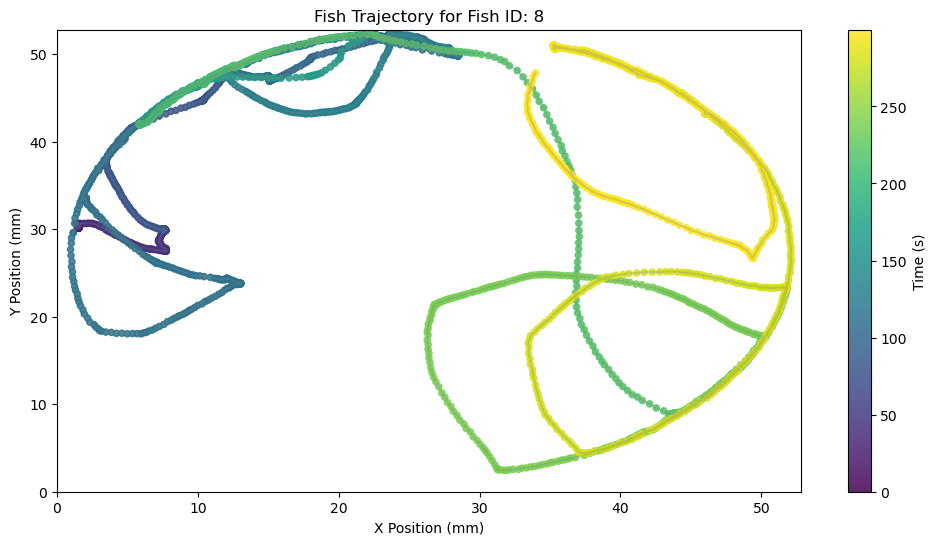

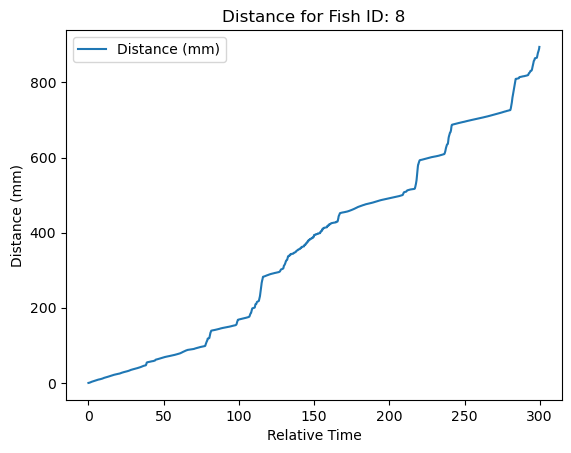

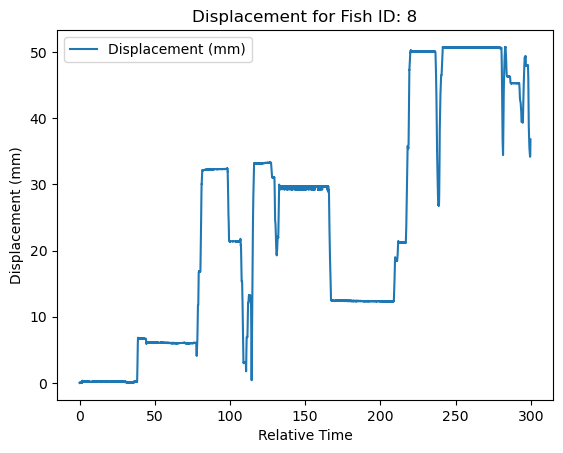

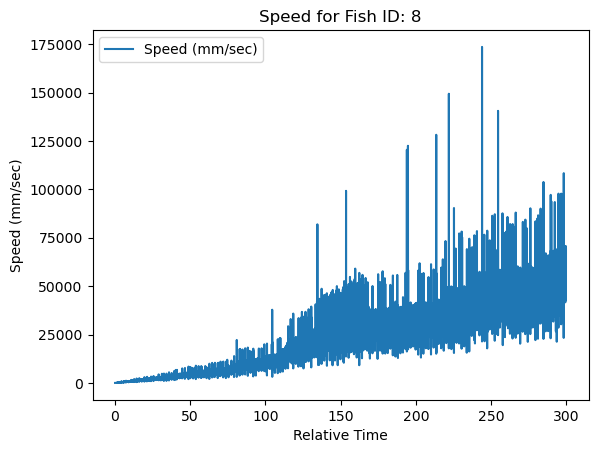

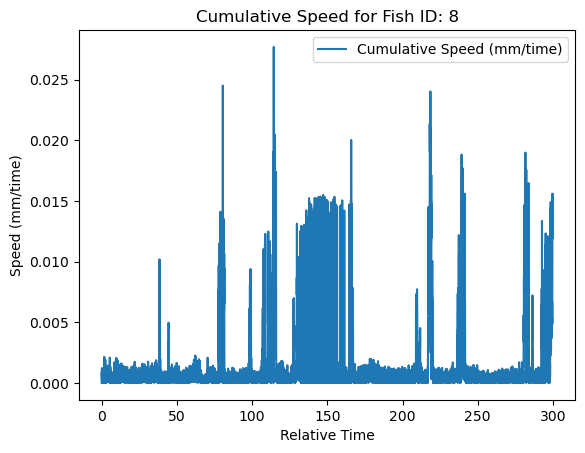

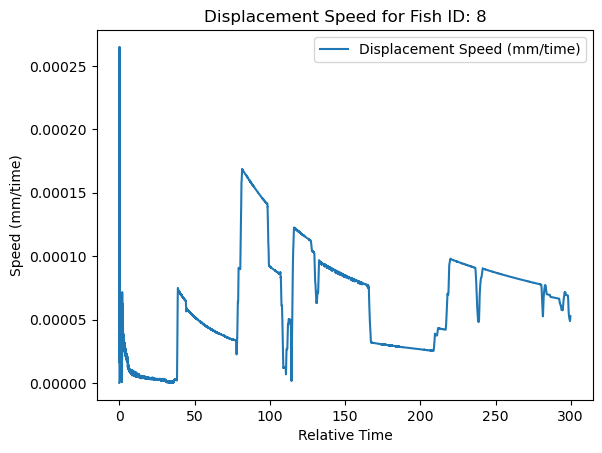

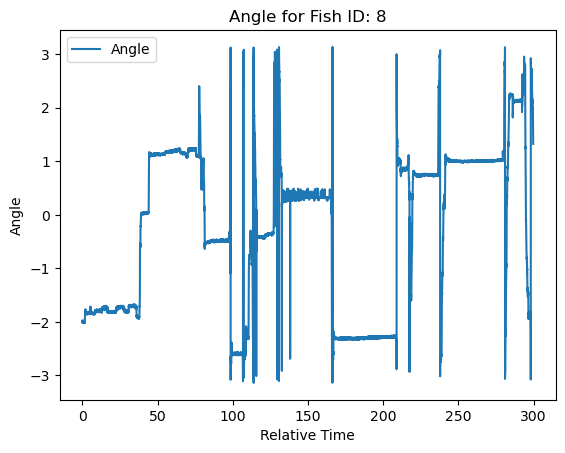

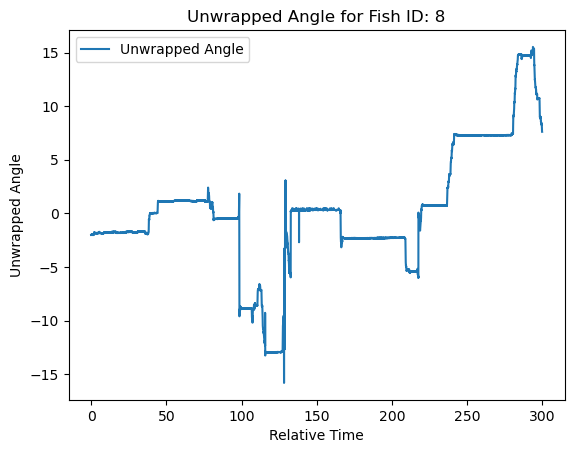

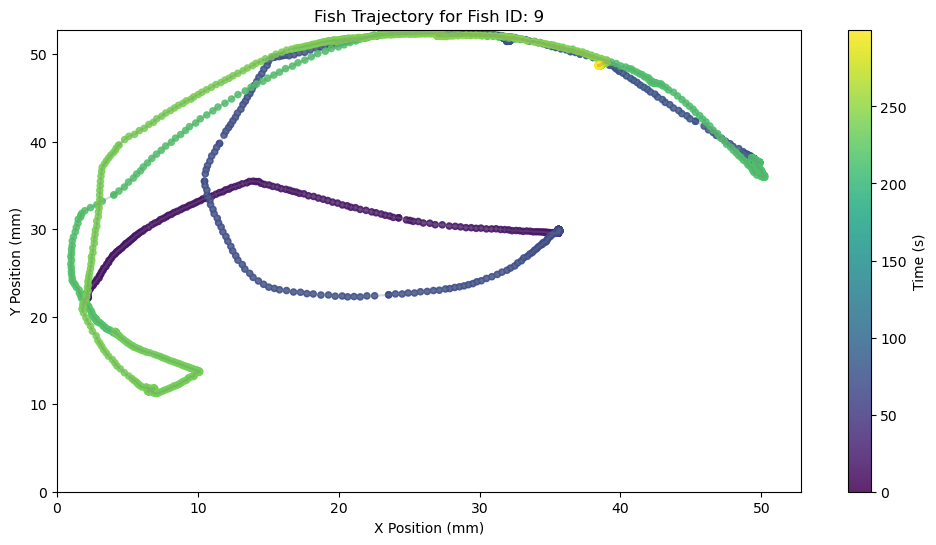

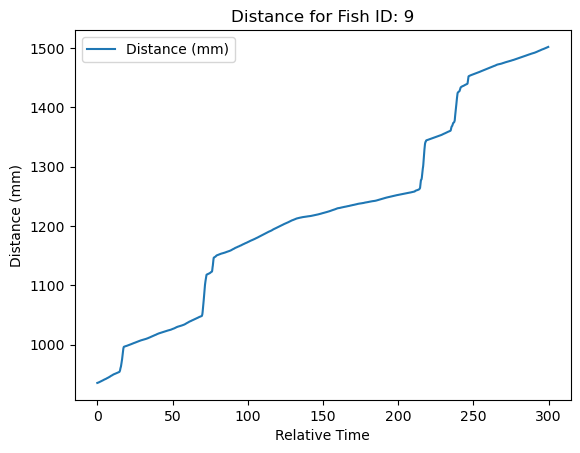

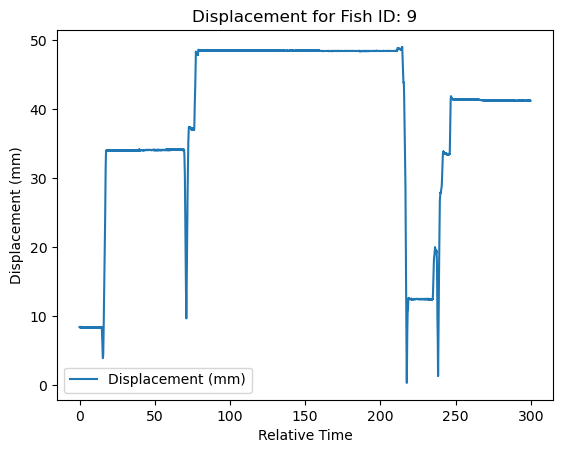

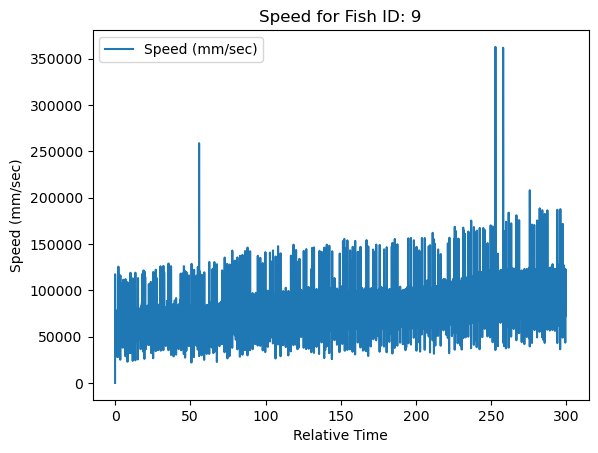

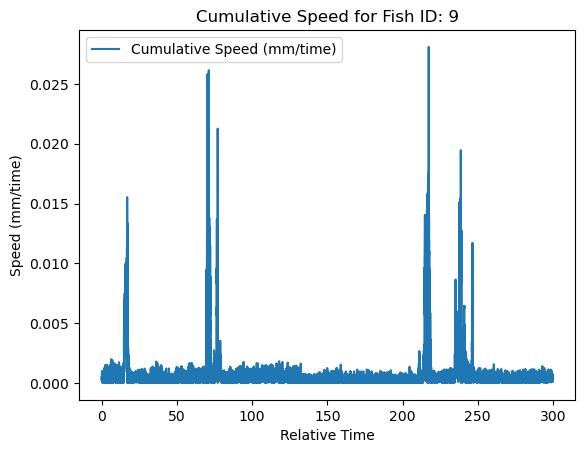

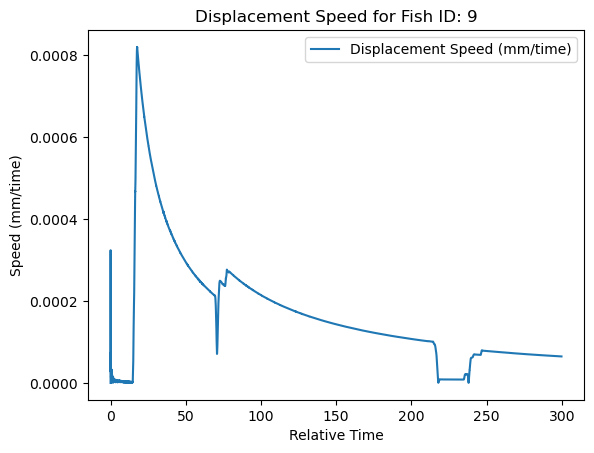

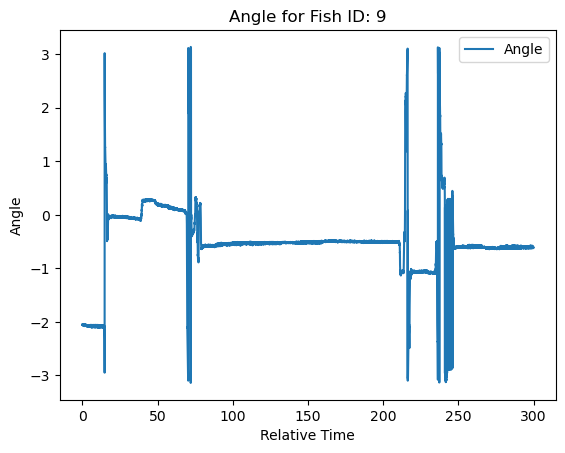

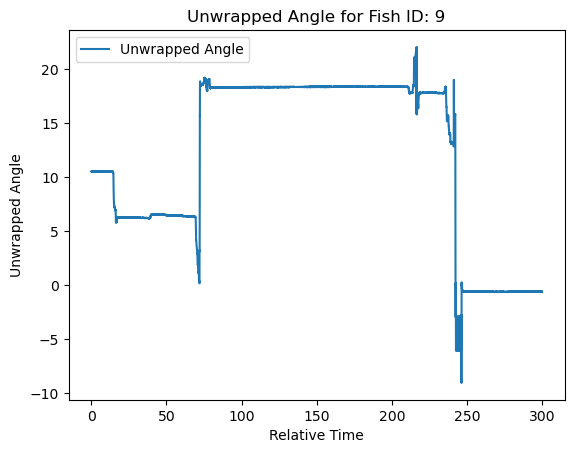

In [42]:
# Load the data
bright_df = pd.read_csv(r'.\bright_data.csv')

# Preprocessing
bright_df['relative_time'] = get_relative_time(bright_df)
bright_df['relative_index'] = get_relative_index(bright_df)
bright_df['distance_mm'] = get_cumulative_distance(bright_df)
bright_df['displacement'] = get_displacement(bright_df)
bright_df['angle'], bright_df['unwrapped_angle'] = get_heading_angle(bright_df)

# Check for outliers in centroid_x and centroid_y
#outliers_x = bright_df[bright_df['centroid_x'] > 2048]
#outliers_y = bright_df[bright_df['centroid_y'] > 2048]
#print(f"Outliers in centroid_x:\n{outliers_x}")
#print(f"Outliers in centroid_y:\n{outliers_y}")
bright_df['centroid_x'] = bright_df['centroid_x'] / PIX_PER_MM
bright_df['centroid_y'] = bright_df['centroid_y'] / PIX_PER_MM

# Calculate speed in mm/sec
bright_df['speed_mm_per_sec'] = bright_df['distance_mm'] / bright_df['relative_time'].diff().fillna(1)


# Group by fish_id and plot separately for each fish
grouped_bright = bright_df.groupby('fish_id')
custom_cmap = plt.cm.get_cmap('viridis')

#print(grouped_bright.head())

for fish_id, group in grouped_bright:
    dpf = group['dpf'].iloc[0]
    
    # Calculate new speeds
    cumulative_speed = get_cumulative_speed(group)
    displacement_speed = get_displacement_speed(group)

    # Trajectory plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        group['centroid_x'], 
        group['centroid_y'], 
        c=group['relative_time'], 
        cmap=custom_cmap, 
        s=20,
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        group['centroid_x'], 
        group['centroid_y'], 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.xlim(0, 2048 / PIX_PER_MM)
    plt.ylim(0, 2048 / PIX_PER_MM)
    plt.show()

    # Distance plot
    plt.figure()
    plt.plot(group['relative_time'], group['distance_mm'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()

    # Displacement plot
    plt.figure()
    plt.plot(group['relative_time'], group['displacement'], label='Displacement (mm)')
    plt.title(f'Displacement for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Displacement (mm)')
    plt.legend()
    plt.show()

    # Original Speed plot
    plt.figure()
    plt.plot(group['relative_time'], group['speed_mm_per_sec'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()

    # Cumulative Speed plot
    plt.figure()
    plt.plot(group['relative_time'], cumulative_speed, label='Cumulative Speed (mm/time)')
    plt.title(f'Cumulative Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/time)')
    plt.legend()
    plt.show()

    # Displacement Speed plot
    plt.figure()
    plt.plot(group['relative_time'], displacement_speed, label='Displacement Speed (mm/time)')
    plt.title(f'Displacement Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/time)')
    plt.legend()
    plt.show()

    # Angle plot
    plt.figure()
    plt.plot(group['relative_time'], group['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle')
    plt.legend()
    plt.show()

    # Unwrapped angle plot
    plt.figure()
    plt.plot(group['relative_time'], group['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle')
    plt.legend()
    plt.show()

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_9156\319856725.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


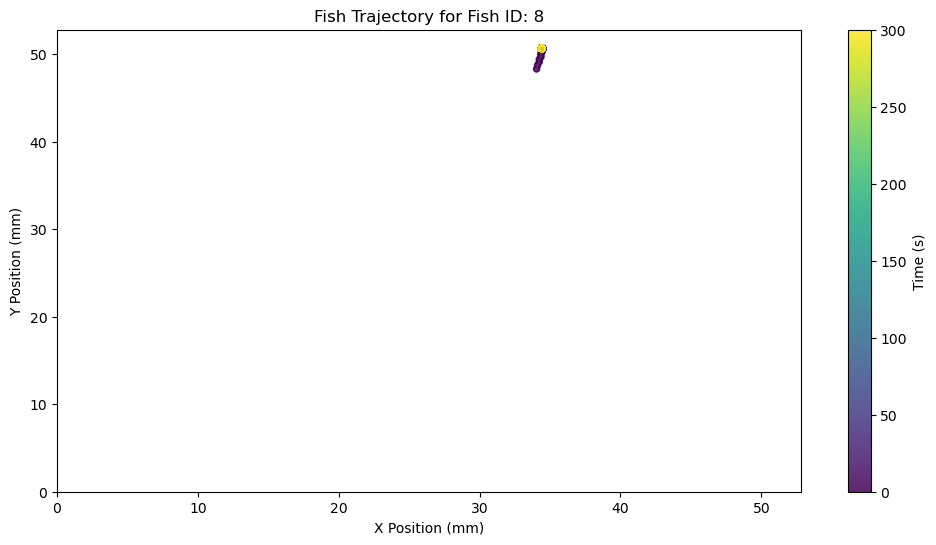

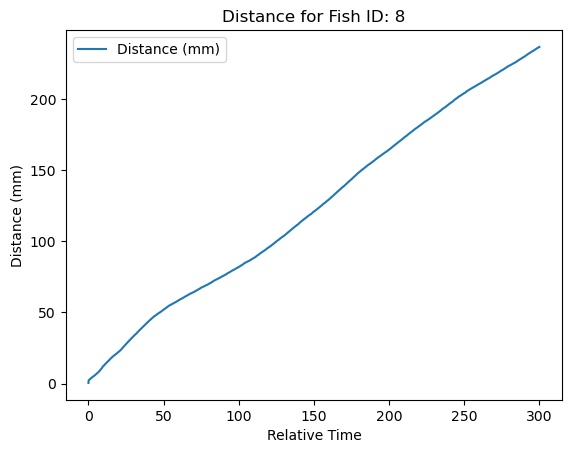

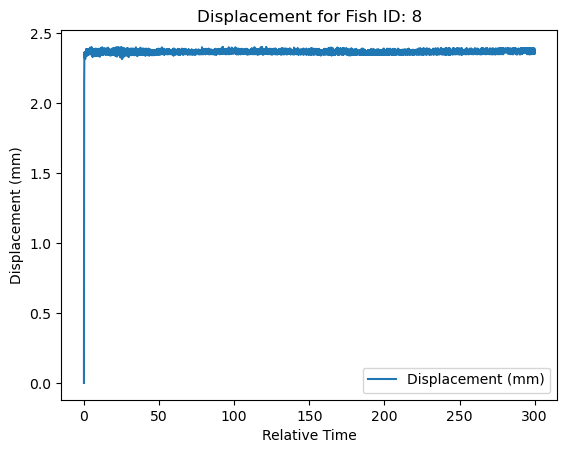

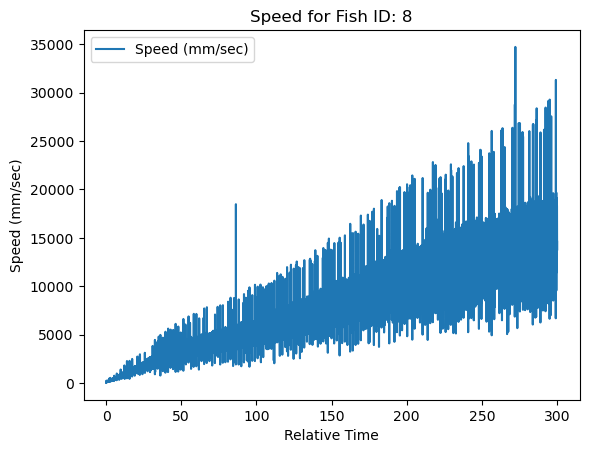

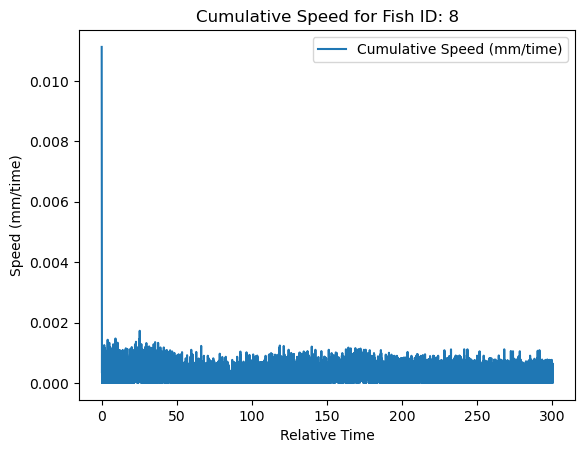

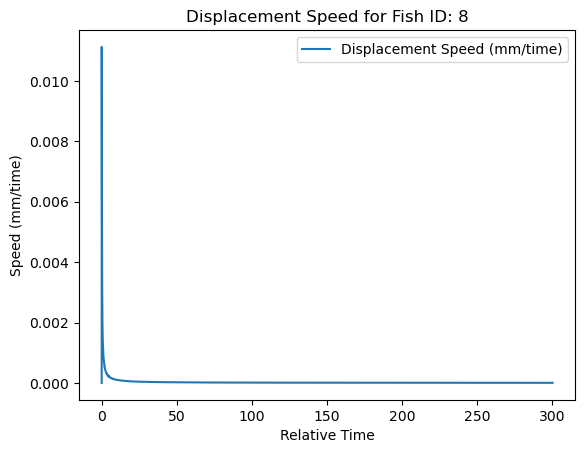

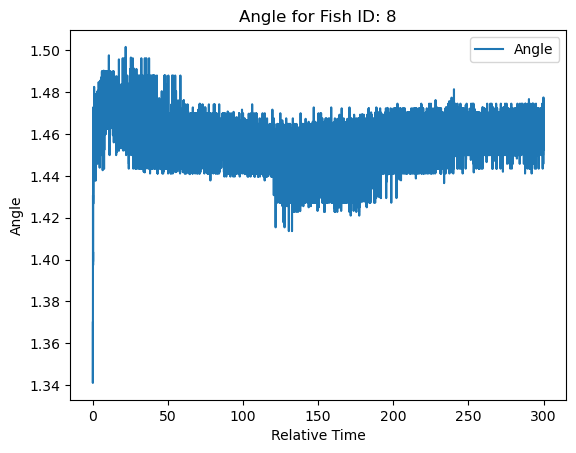

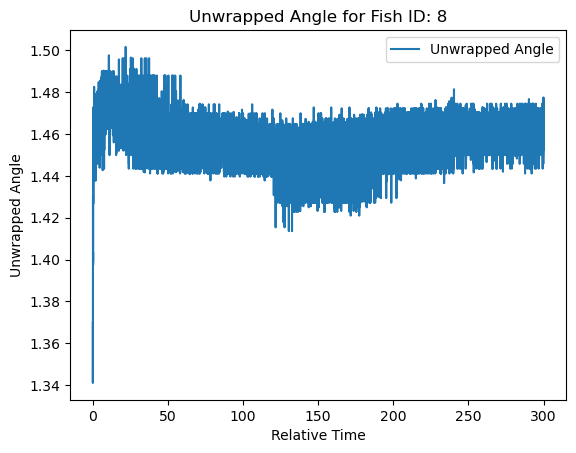

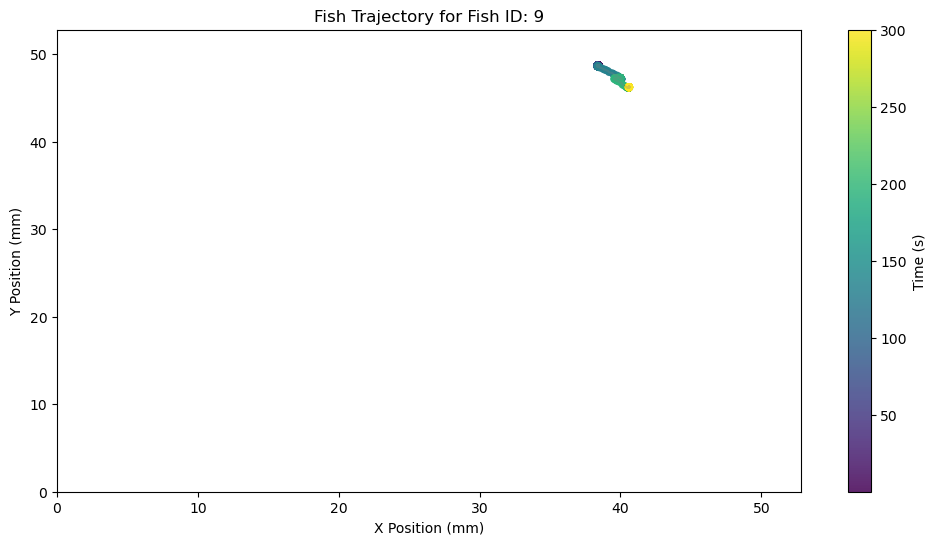

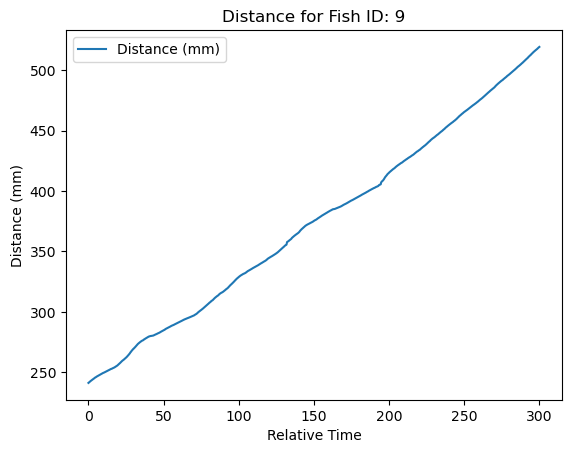

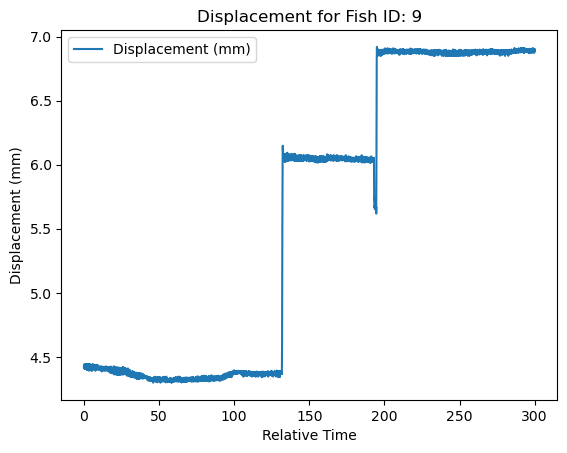

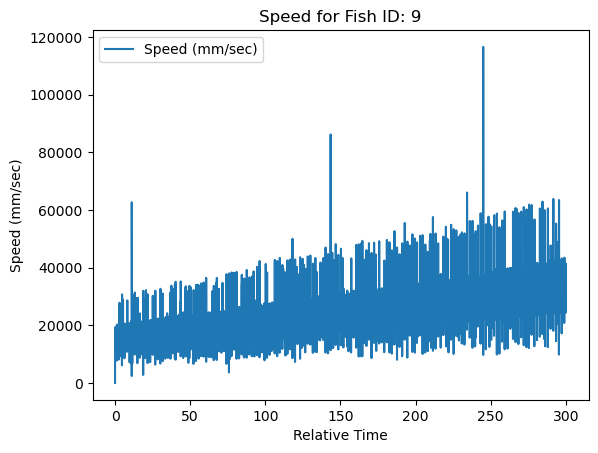

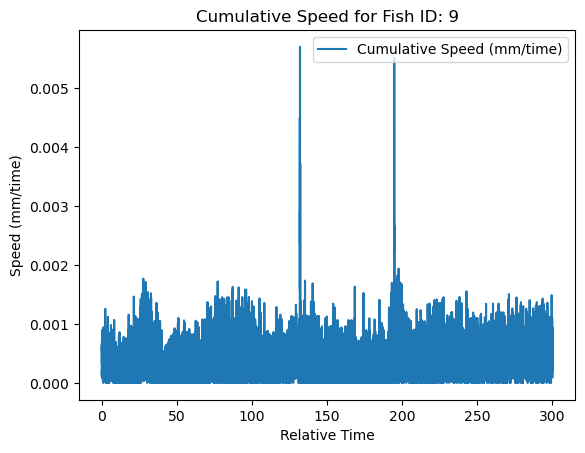

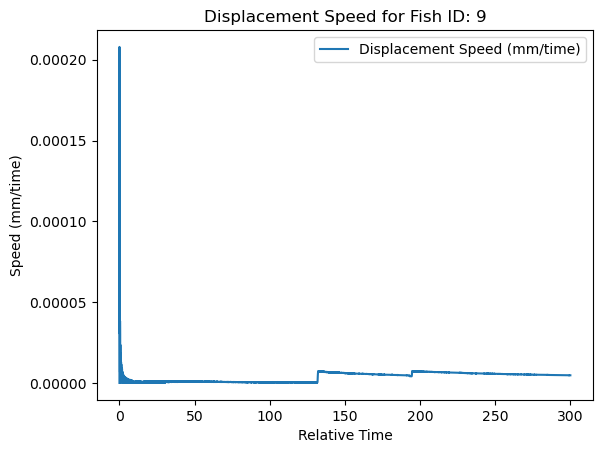

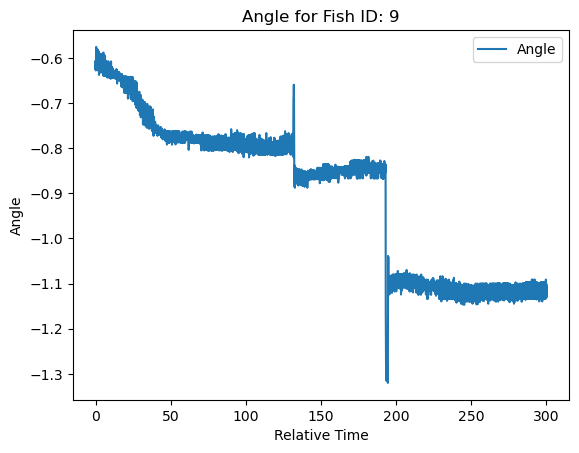

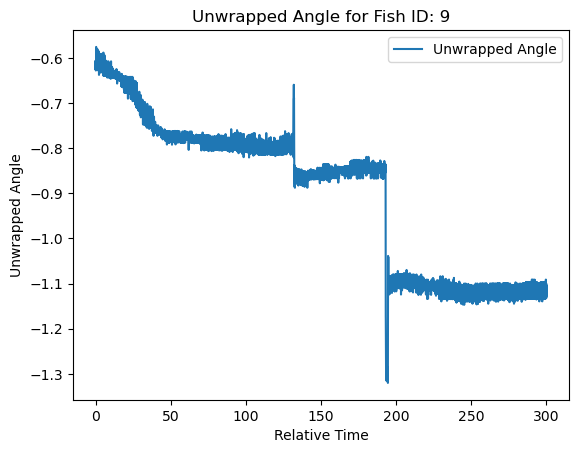

In [43]:
# Load the data
dark_df = pd.read_csv(r'.\dark_data.csv')

# Preprocessing
dark_df['relative_time'] = get_relative_time(dark_df)
dark_df['relative_index'] = get_relative_index(dark_df)
dark_df['distance_mm'] = get_cumulative_distance(dark_df)
dark_df['displacement'] = get_displacement(dark_df)
dark_df['angle'], dark_df['unwrapped_angle'] = get_heading_angle(dark_df)

# Check for outliers in centroid_x and centroid_y
#outliers_x = dark_df[dark_df['centroid_x'] > 2048]
#outliers_y = dark_df[dark_df['centroid_y'] > 2048]
#print(f"Outliers in centroid_x:\n{outliers_x}")
#print(f"Outliers in centroid_y:\n{outliers_y}")
dark_df['centroid_x'] = dark_df['centroid_x'] / PIX_PER_MM
dark_df['centroid_y'] = dark_df['centroid_y'] / PIX_PER_MM

# Calculate speed in mm/sec
dark_df['speed_mm_per_sec'] = dark_df['distance_mm'] / dark_df['relative_time'].diff().fillna(1)


# Group by fish_id and plot separately for each fish
grouped_dark = dark_df.groupby('fish_id')
custom_cmap = plt.cm.get_cmap('viridis')

#print(grouped_dark.head())

for fish_id, group in grouped_dark:
    dpf = group['dpf'].iloc[0]
    
    # Calculate new speeds
    cumulative_speed = get_cumulative_speed(group)
    displacement_speed = get_displacement_speed(group)

    # Trajectory plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        group['centroid_x'], 
        group['centroid_y'], 
        c=group['relative_time'], 
        cmap=custom_cmap, 
        s=20,
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        group['centroid_x'], 
        group['centroid_y'], 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.xlim(0, 2048 / PIX_PER_MM)
    plt.ylim(0, 2048 / PIX_PER_MM)
    plt.show()

    # Distance plot
    plt.figure()
    plt.plot(group['relative_time'], group['distance_mm'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()

    # Displacement plot
    plt.figure()
    plt.plot(group['relative_time'], group['displacement'], label='Displacement (mm)')
    plt.title(f'Displacement for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Displacement (mm)')
    plt.legend()
    plt.show()

    # Original Speed plot
    plt.figure()
    plt.plot(group['relative_time'], group['speed_mm_per_sec'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()

    # Cumulative Speed plot
    plt.figure()
    plt.plot(group['relative_time'], cumulative_speed, label='Cumulative Speed (mm/time)')
    plt.title(f'Cumulative Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/time)')
    plt.legend()
    plt.show()

    # Displacement Speed plot
    plt.figure()
    plt.plot(group['relative_time'], displacement_speed, label='Displacement Speed (mm/time)')
    plt.title(f'Displacement Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/time)')
    plt.legend()
    plt.show()

    # Angle plot
    plt.figure()
    plt.plot(group['relative_time'], group['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle')
    plt.legend()
    plt.show()

    # Unwrapped angle plot
    plt.figure()
    plt.plot(group['relative_time'], group['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle')
    plt.legend()
    plt.show()

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_9156\40335514.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


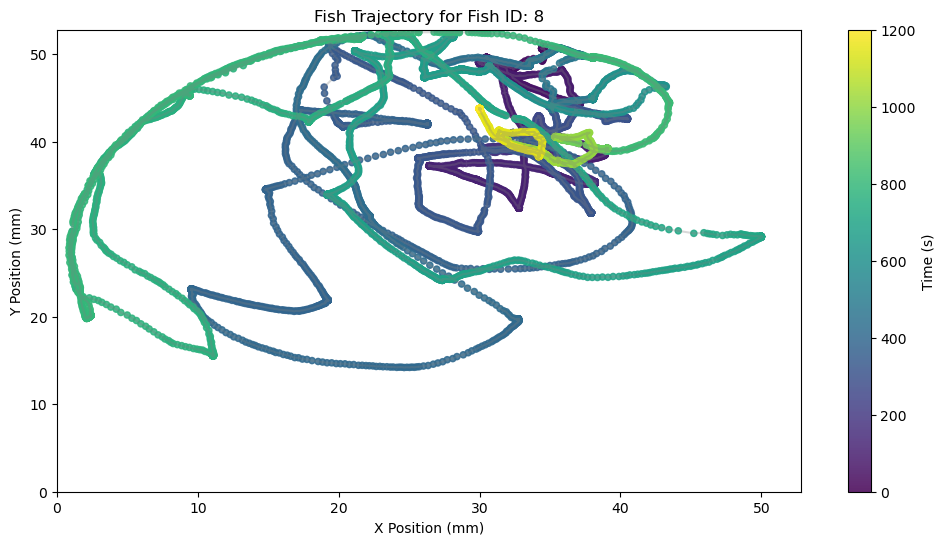

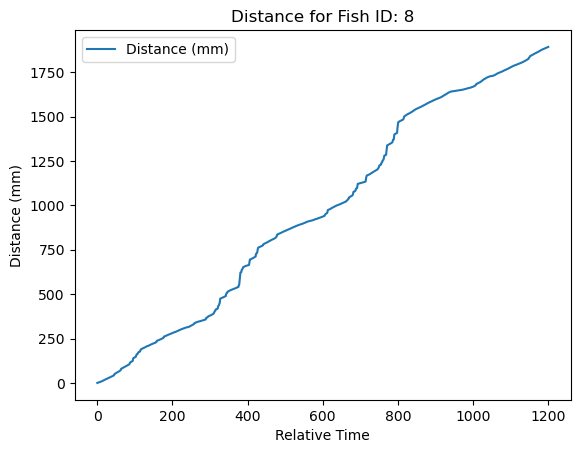

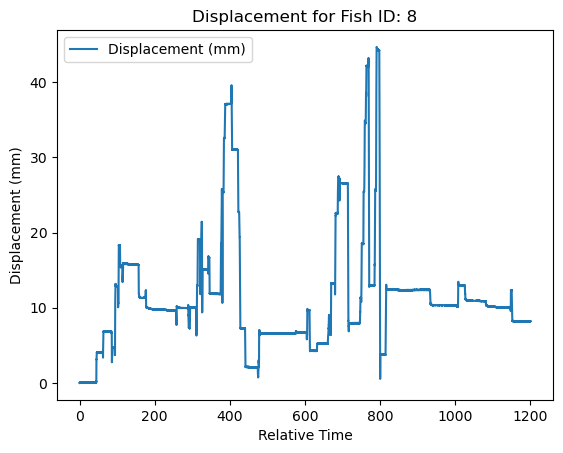

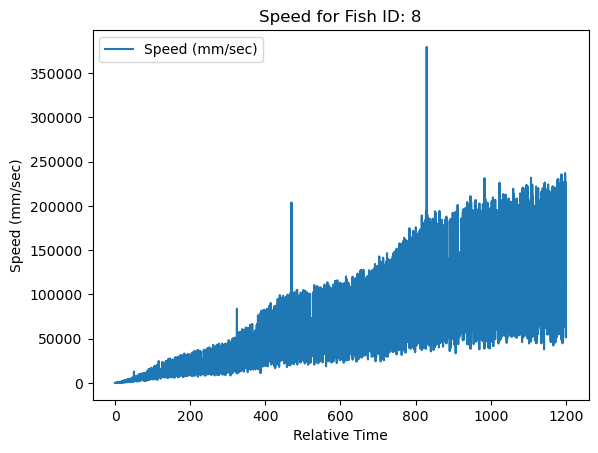

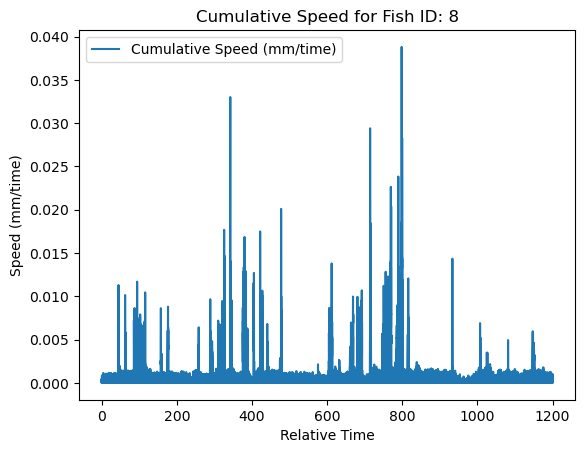

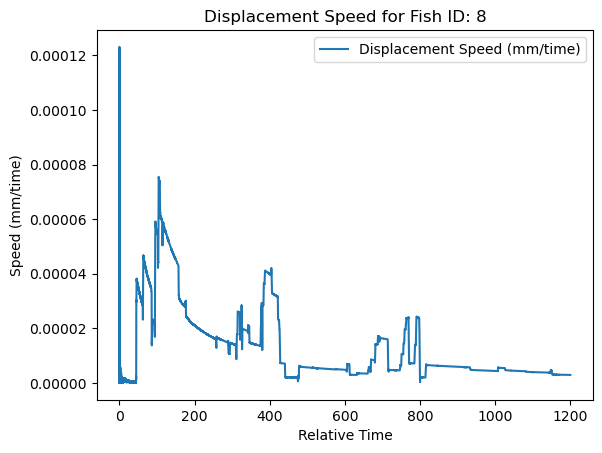

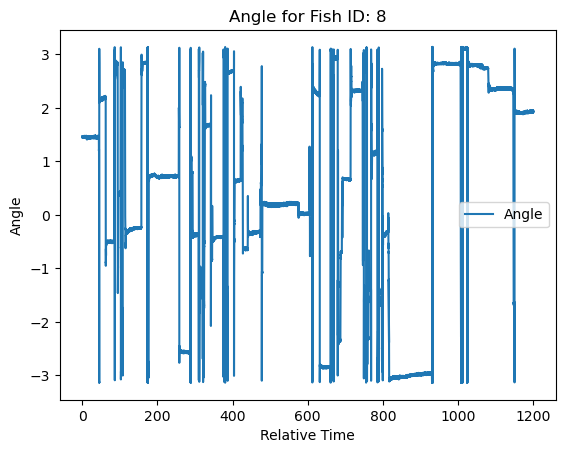

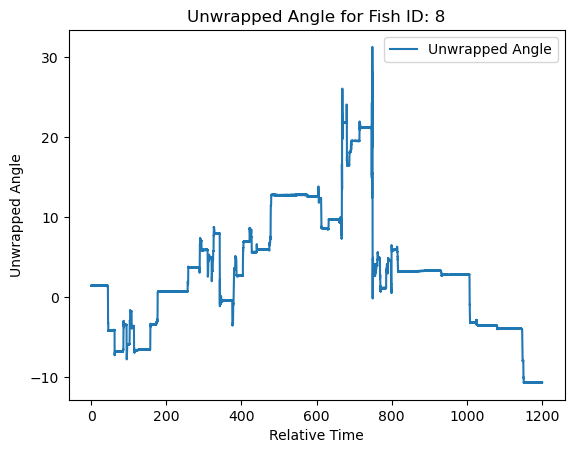

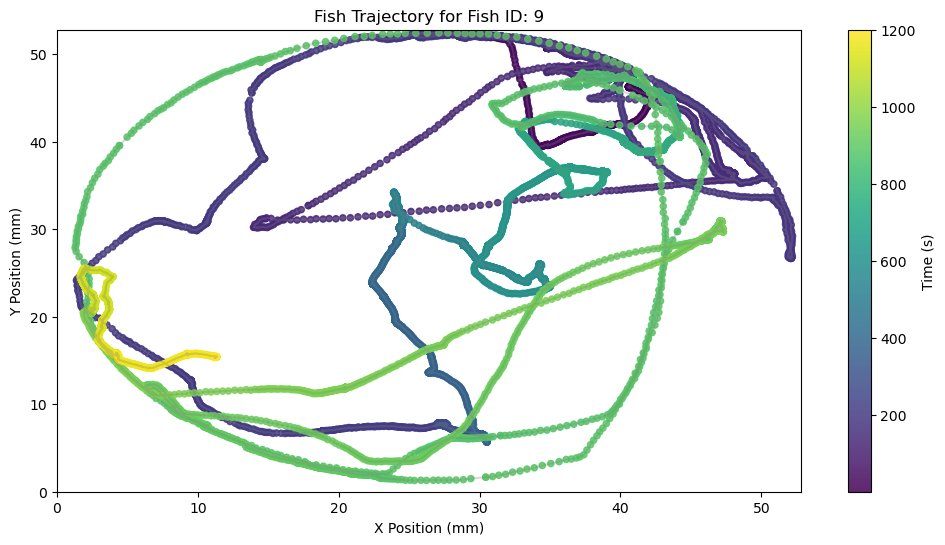

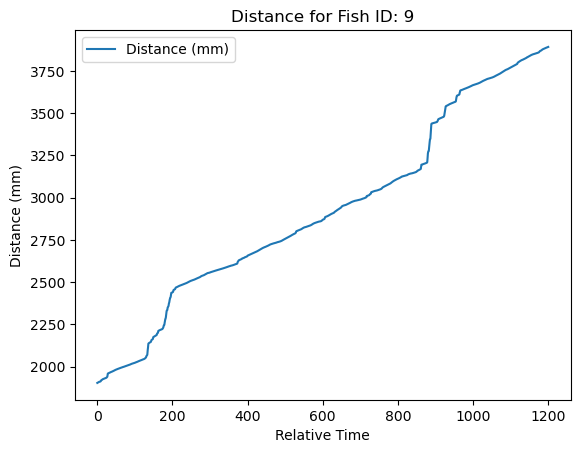

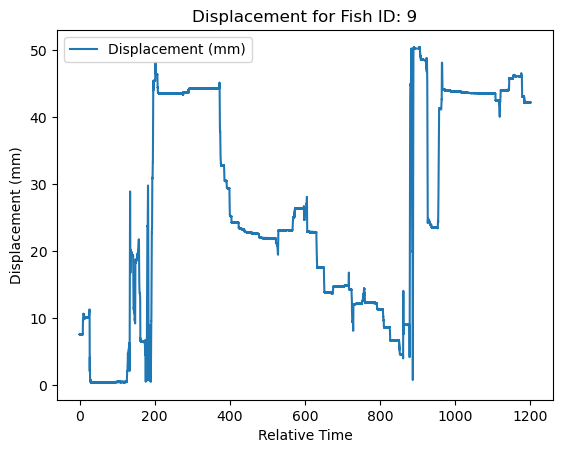

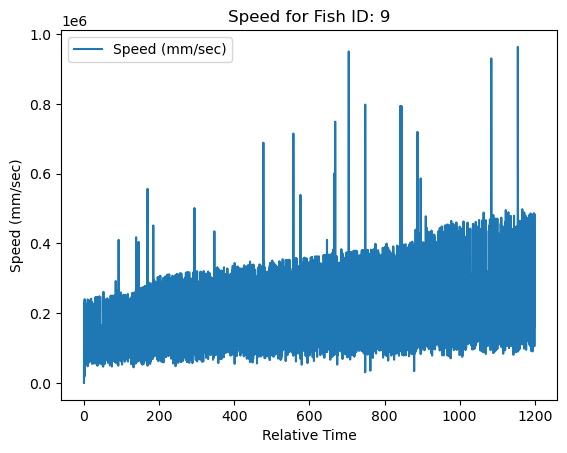

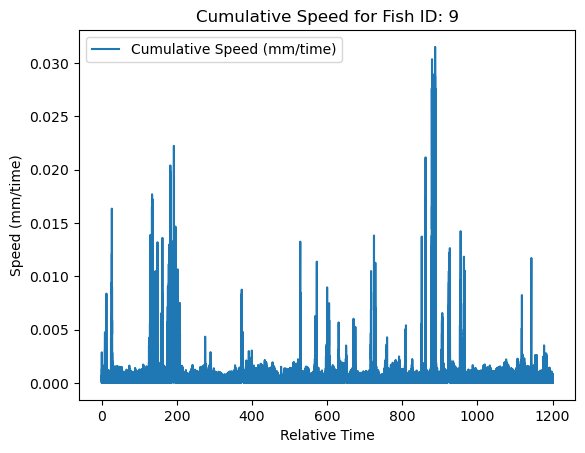

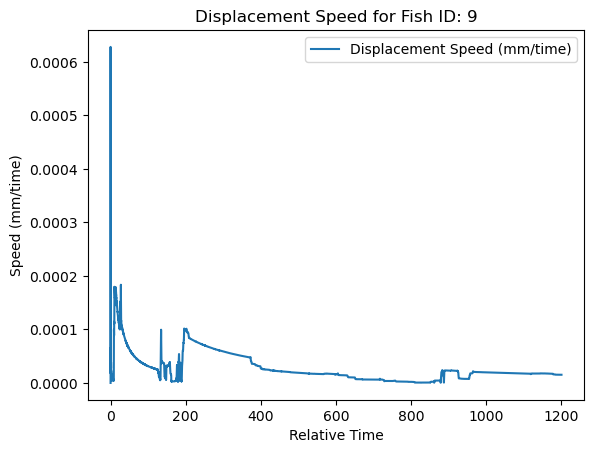

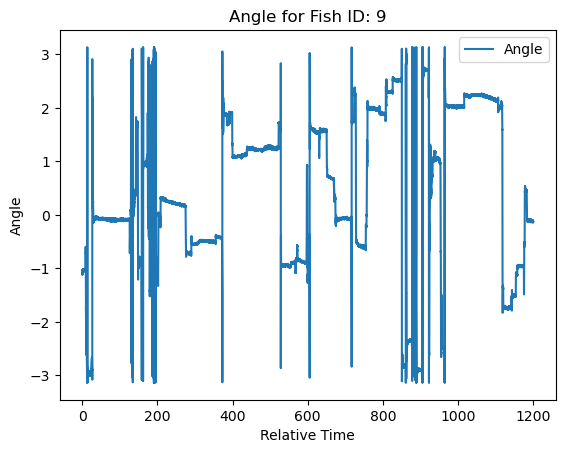

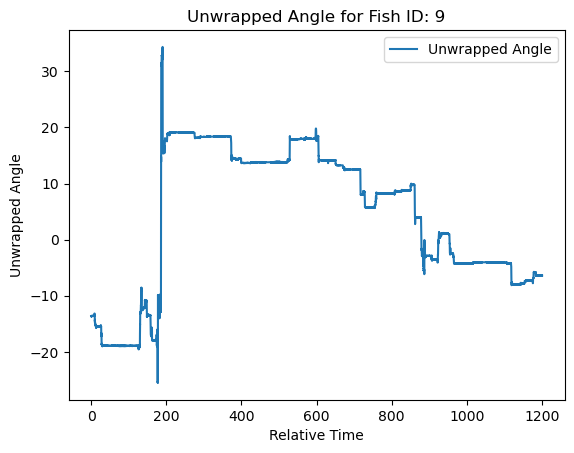

In [44]:
# Load the data
phototaxis_df = pd.read_csv(r'.\phototaxis_data.csv')

# Preprocessing
phototaxis_df['relative_time'] = get_relative_time(phototaxis_df)
phototaxis_df['relative_index'] = get_relative_index(phototaxis_df)
phototaxis_df['distance_mm'] = get_cumulative_distance(phototaxis_df)
phototaxis_df['displacement'] = get_displacement(phototaxis_df)
phototaxis_df['angle'], phototaxis_df['unwrapped_angle'] = get_heading_angle(phototaxis_df)

# Check for outliers in centroid_x and centroid_y
#outliers_x = phototaxis_df[phototaxis_df['centroid_x'] > 2048]
#outliers_y = phototaxis_df[phototaxis_df['centroid_y'] > 2048]
#print(f"Outliers in centroid_x:\n{outliers_x}")
#print(f"Outliers in centroid_y:\n{outliers_y}")
phototaxis_df['centroid_x'] = phototaxis_df['centroid_x'] / PIX_PER_MM
phototaxis_df['centroid_y'] = phototaxis_df['centroid_y'] / PIX_PER_MM

# Calculate speed in mm/sec
phototaxis_df['speed_mm_per_sec'] = phototaxis_df['distance_mm'] / phototaxis_df['relative_time'].diff().fillna(1)


# Group by fish_id and plot separately for each fish
grouped_phototaxis = phototaxis_df.groupby('fish_id')
custom_cmap = plt.cm.get_cmap('viridis')

#print(grouped_phototaxis.head())

for fish_id, group in grouped_phototaxis:
    dpf = group['dpf'].iloc[0]
    
    # Calculate new speeds
    cumulative_speed = get_cumulative_speed(group)
    displacement_speed = get_displacement_speed(group)

    # Trajectory plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        group['centroid_x'], 
        group['centroid_y'], 
        c=group['relative_time'], 
        cmap=custom_cmap, 
        s=20,
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        group['centroid_x'], 
        group['centroid_y'], 
        color='gray', 
        linewidth=1.5, 
        alpha=0.3
    )
    plt.xlim(0, 2048 / PIX_PER_MM)
    plt.ylim(0, 2048 / PIX_PER_MM)
    plt.show()

    # Distance plot
    plt.figure()
    plt.plot(group['relative_time'], group['distance_mm'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()

    # Displacement plot
    plt.figure()
    plt.plot(group['relative_time'], group['displacement'], label='Displacement (mm)')
    plt.title(f'Displacement for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Displacement (mm)')
    plt.legend()
    plt.show()

    # Original Speed plot
    plt.figure()
    plt.plot(group['relative_time'], group['speed_mm_per_sec'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()

    # Cumulative Speed plot
    plt.figure()
    plt.plot(group['relative_time'], cumulative_speed, label='Cumulative Speed (mm/time)')
    plt.title(f'Cumulative Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/time)')
    plt.legend()
    plt.show()

    # Displacement Speed plot
    plt.figure()
    plt.plot(group['relative_time'], displacement_speed, label='Displacement Speed (mm/time)')
    plt.title(f'Displacement Speed for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/time)')
    plt.legend()
    plt.show()

    # Angle plot
    plt.figure()
    plt.plot(group['relative_time'], group['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle')
    plt.legend()
    plt.show()

    # Unwrapped angle plot
    plt.figure()
    plt.plot(group['relative_time'], group['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle')
    plt.legend()
    plt.show()

In [7]:




def analyse_phototaxis(data, fish_id, dpf):
    phototaxis = data[data['stim_id'] == StimType.PHOTOTAXIS]

    def get_data(polarity):
        pol = phototaxis[phototaxis['phototaxis_polarity'] == polarity]
        time = get_relative_time(pol)
        angle, angle_unwrapped = get_heading_angle(pol)
        res = pd.DataFrame({
            'time': time, 
            'angle': angle, 
            'angle_unwrapped': angle_unwrapped,
            'polarity': polarity,
            'fish_id': fish_id,
            'dpf': dpf
        })
        res = res.set_index(get_relative_index(pol))
        return res

    res = pd.concat((get_data(1),get_data(-1)))
    return res



def plot_heading_angle(data):
    angle, angle_unwrapped = get_heading_angle(data)
    distance = get_distance(data)

    plt.figure()
    ax1 = plt.subplot(311)
    ax1.plot(
        data['t_local'], 
        angle
    )
    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(
        data['t_local'], 
        angle_unwrapped
    )
    ax2.set_ylabel('cum. angle')
    ax3 = plt.subplot(313, sharex=ax1)
    ax3.plot(
        data['t_local'], 
        distance
    )
    ax3.set_ylabel('distance')
    plt.show()

In [8]:
DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    "08_09dpf_Di_27_Aug_2024_14h50min47sec.csv", 
    "09_09dpf_Di_27_Aug_2024_16h03min14sec.csv"
]

phototaxis = pd.DataFrame()

for file in DATAFILES:
    print(file)
    fish_id, dpf, date = parse_filename(file)
    data = pd.read_csv(os.path.join(DATA_FOLDER,file))
    data_filtered = data.groupby('image_index').first()
    data_filtered = data_filtered[1:]
    data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
    #phototaxis = data_filtered[['t_display', 't_local', 'latency', 'centroid_x', 'centroid_y', 'pc1_x',
     #  'pc1_y', 'pc2_x', 'pc2_y',]] 
    phototaxis = pd.concat((
        phototaxis, 
        analyse_phototaxis(data_filtered, fish_id, dpf)
    ))

    ## save 
phototaxis.to_csv('phototaxis.csv')

## load
phototaxis = pd.read_csv('phototaxis.csv')
print(phototaxis.head)

08_09dpf_Di_27_Aug_2024_14h50min47sec.csv
09_09dpf_Di_27_Aug_2024_16h03min14sec.csv
<bound method NDFrame.head of         image_index        time     angle  angle_unwrapped  polarity  fish_id  \
0                 0    0.000000  0.025864         0.025864         1        8   
1                 1    0.016780  0.025864         0.025864         1        8   
2                 2    0.037573  0.034523         0.034523         1        8   
3                 3    0.050093  0.018354         0.018354         1        8   
4                 4    0.066864  0.011306         0.011306         1        8   
...             ...         ...       ...              ...       ...      ...   
144008        36000  600.003596 -1.213488        30.202439        -1        9   
144009        36001  600.020272 -1.244798        30.171129        -1        9   
144010        36002  600.036948 -1.222917        30.193010        -1        9   
144011        36003  600.053653 -1.178235        30.237691        -1        

In [9]:
print(phototaxis.columns)

Index(['image_index', 'time', 'angle', 'angle_unwrapped', 'polarity',
       'fish_id', 'dpf'],
      dtype='object')


In [10]:
print(phototaxis.columns)

Index(['image_index', 'time', 'angle', 'angle_unwrapped', 'polarity',
       'fish_id', 'dpf'],
      dtype='object')


In [11]:
phototaxis.shape

(144013, 7)

In [12]:
phototaxis.shape

(144013, 7)

In [13]:
phototaxis.isnull().any()

image_index        False
time               False
angle              False
angle_unwrapped    False
polarity           False
fish_id            False
dpf                False
dtype: bool

In [14]:
data_filtered.isnull().sum()

t_display                             0
t_local                               0
latency                               0
centroid_x                            0
centroid_y                            0
                                     ..
looming_center_mm_x                   0
looming_center_mm_y                   0
looming_period_sec                    0
looming_expansion_time_sec            0
looming_expansion_speed_mm_per_sec    0
Length: 107, dtype: int64

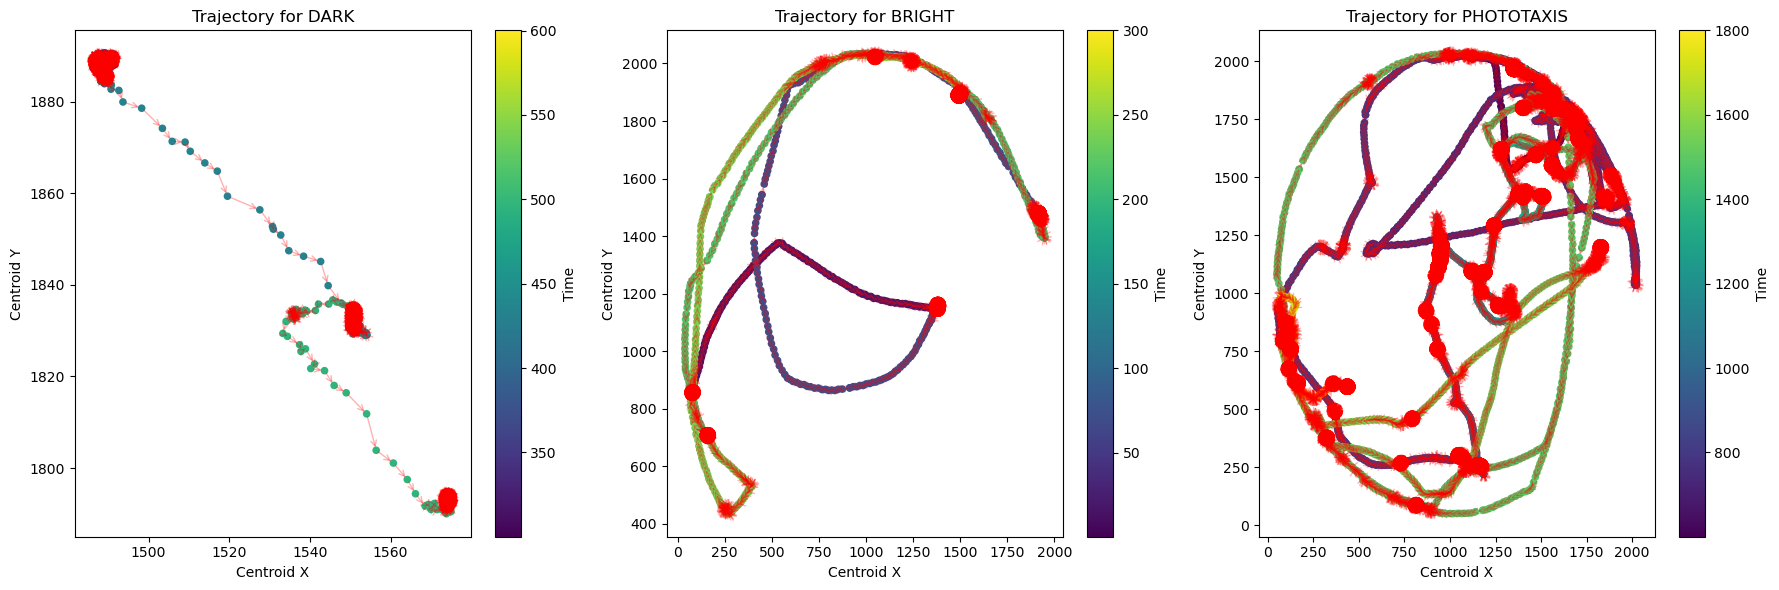

In [ ]:
def plot_fish_trajectories(data):
    # Create a figure with subplots for each stimulus type
    stim_types = [StimType.DARK, StimType.phototaxis, StimType.PHOTOTAXIS]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, stim_type in enumerate(stim_types):
        # Filter data for specific stimulus type
        stim_data = data[data['stim_id'] == stim_type]
        
        # Create scatter plot with color gradient based on time
        scatter = axes[i].scatter(
            stim_data['centroid_x'], 
            stim_data['centroid_y'],
            c=stim_data['t_local'],  # Color based on time
            cmap='viridis',       # Color gradient
            s=20                  # Point size
        )
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i], label='Time')
        
        # Set labels and title
        axes[i].set_title(f'Trajectory for {stim_type.name}')
        axes[i].set_xlabel('Centroid X')
        axes[i].set_ylabel('Centroid Y')
        
        # Optional: add arrows to show direction
        for j in range(len(stim_data)-1):
            axes[i].annotate('', 
                xy=(stim_data['centroid_x'].iloc[j+1], stim_data['centroid_y'].iloc[j+1]),
                xytext=(stim_data['centroid_x'].iloc[j], stim_data['centroid_y'].iloc[j]),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.3)
            )
    
    plt.tight_layout()
    plt.show()

# Assuming 'data' is your preprocessed DataFrame
plot_fish_trajectories(data_filtered)